In [27]:
import pandas as pd
import numpy as np
from arch import arch_model
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('hi1_20170701_20200609.csv', sep=',')
'''
# Check column names
print("Column names:", df.columns.tolist())
print("First few rows:")
print(df.head())
'''

'''
# Assuming the first column is date and second is time, but they might have different names
date_col = df.columns[0]
time_col = df.columns[1]
print(f"Using '{date_col}' as date column and '{time_col}' as time column")

# Convert date and time to proper format
df[date_col] = df[date_col].astype(str)
df[time_col] = df[time_col].astype(str).str.zfill(6)

# Convert price and volume columns to numeric
price_cols = [col for col in df.columns[2:]]
for col in price_cols:
    df[col] = pd.to_numeric(df[col])
'''


# Convert columns to appropriate types
df['date'] = df['date'].astype(str)
df['time'] = df['time'].astype(str)
numeric_cols = ['hi1_open', 'hi1_high', 'hi1_low', 'hi1_close', 'hi1_volume']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Create datetime for sorting, but keep original date and time columns
#df['datetime'] = pd.to_datetime(df['date'] + df['time'], format='%Y%m%d%H%M%S')
#df = df.sort_values('datetime')

# Function to calculate HAR signals
def calculate_har_signals(prices, lags=[1, 5, 22]):
    # Calculate log returns
    returns = np.log(prices / prices.shift(1)).dropna()
    
    # Create lagged returns for HAR model
    har_terms = {}
    for lag in lags:
        har_terms[f'har_{lag}'] = returns.rolling(window=lag).mean().shift(1)
    
    # Create a DataFrame with HAR terms
    har_df = pd.DataFrame(har_terms)
    har_df = pd.concat([returns, har_df], axis=1).dropna()
    
    # Fit HAR model
    y = har_df.iloc[:, 0].values
    X = har_df.iloc[:, 1:].values
    
    if len(y) < 30:  # Minimum data requirement
        return pd.Series(np.nan, index=prices.index)
    
    # Simple regression model to approximate HAR
    model = np.linalg.lstsq(np.hstack([np.ones((X.shape[0], 1)), X]), y, rcond=None)[0]
    
    # Generate predictions for the entire series
    preds = np.zeros(len(prices))
    preds[:] = np.nan
    
    # Fill predictions where we have all HAR terms
    valid_idx = har_df.index
    X_with_const = np.hstack([np.ones((X.shape[0], 1)), X])
    preds_valid = np.dot(X_with_const, model)
    
    for i, idx in enumerate(valid_idx):
        pos = prices.index.get_loc(idx)
        preds[pos] = preds_valid[i]
    
    # Convert to signals: 1 for buy, -1 for sell, 0 for hold
    signals = pd.Series(0, index=prices.index)
    signals.loc[prices.index[preds > 0.0001]] = 1  # Threshold for buy signal
    signals.loc[prices.index[preds < -0.0001]] = -1  # Threshold for sell signal
    
    return signals

# Trading function
def trade_day(day_data, initial_margin=20000, max_margin=15000):
    position = 0  # 0: flat, positive: long, negative: short
    cash = 0  # Profit/loss in HSI points
    trades = []
    
    # Calculate HAR signals
    signals = calculate_har_signals(day_data['hi1_close'])
    
    # Loop through each minute
    for i, (idx, row) in enumerate(day_data.iterrows()):
        price = row['hi1_close']
        time = int(row['time'])
        signal = signals.loc[idx] if idx in signals.index else 0
        
        # Check if we're in the last 60 minutes of trading
        last_hour = i >= len(day_data) - 60
        
        # Determine action based on position and signal
        if position > 0:  # Long position
            if signal < 0 or last_hour:  # Sell signal or last hour
                # Close position
                cash += position * price - position * 0.2  # Price + fee
                trades.append(("SELL", position, price, cash))
                position = 0
            elif signal > 0 and not last_hour:  # Buy signal and not in last hour
                # Check margin requirement for adding one more contract
                required_margin = (position + 1) * price * 0.1
                if required_margin <= max_margin:
                    cash -= price + 0.2  # Price + fee
                    position += 1
                    trades.append(("BUY", 1, price, cash))
        
        elif position < 0:  # Short position
            if signal > 0 or last_hour:  # Buy signal or last hour
                # Close position
                cash -= -position * price + -position * 0.2  # Price + fee
                trades.append(("BUY", -position, price, cash))
                position = 0
            elif signal < 0 and not last_hour:  # Sell signal and not in last hour
                # Check margin requirement for adding one more contract
                required_margin = (abs(position) + 1) * price * 0.1
                if required_margin <= max_margin:
                    cash += price - 0.2  # Price + fee
                    position -= 1
                    trades.append(("SELL", 1, price, cash))
        
        else:  # Flat position
            if signal > 0 and not last_hour:  # Buy signal and not in last hour
                required_margin = price * 0.1
                if required_margin <= max_margin:
                    cash -= price + 0.2  # Price + fee
                    position = 1
                    trades.append(("BUY", 1, price, cash))
            elif signal < 0 and not last_hour:  # Sell signal and not in last hour
                required_margin = price * 0.1
                if required_margin <= max_margin:
                    cash += price - 0.2  # Price + fee
                    position = -1
                    trades.append(("SELL", 1, price, cash))
    
    # Force close any remaining position at the end of the day
    if position > 0:
        last_price = day_data.iloc[-1]['hi1_close']
        cash += position * last_price - position * 0.2
        trades.append(("SELL", position, last_price, cash))
    elif position < 0:
        last_price = day_data.iloc[-1]['hi1_close']
        cash -= -position * last_price + -position * 0.2
        trades.append(("BUY", -position, last_price, cash))
    
    return cash, trades

# Trade day by day
unique_dates = df['date'].unique()
daily_pnl = []

for date in unique_dates:
    if date == '20171009':
        break
    day_data = df[df['date'] == date].copy()
    if len(day_data) < 10:  # Skip days with insufficient data
        continue
    
    pnl, trades = trade_day(day_data)
    daily_pnl.append(pnl)
    print(f"Date: {date}, Daily P&L: {pnl:.2f} HSI points")



Date: 20170703, Daily P&L: 243.00 HSI points
Date: 20170704, Daily P&L: 78.20 HSI points
Date: 20170705, Daily P&L: 244.60 HSI points
Date: 20170706, Daily P&L: 0.00 HSI points
Date: 20170707, Daily P&L: 206.40 HSI points
Date: 20170710, Daily P&L: 109.00 HSI points
Date: 20170711, Daily P&L: 152.80 HSI points
Date: 20170712, Daily P&L: 456.80 HSI points
Date: 20170713, Daily P&L: 13.60 HSI points
Date: 20170714, Daily P&L: 333.20 HSI points
Date: 20170717, Daily P&L: 310.20 HSI points
Date: 20170718, Daily P&L: 0.00 HSI points
Date: 20170719, Daily P&L: 0.00 HSI points
Date: 20170720, Daily P&L: 0.00 HSI points
Date: 20170721, Daily P&L: -1.40 HSI points
Date: 20170724, Daily P&L: 91.00 HSI points
Date: 20170725, Daily P&L: 0.00 HSI points
Date: 20170726, Daily P&L: 0.00 HSI points
Date: 20170727, Daily P&L: 155.60 HSI points
Date: 20170728, Daily P&L: 1.40 HSI points
Date: 20170731, Daily P&L: -53.40 HSI points
Date: 20170801, Daily P&L: 0.00 HSI points
Date: 20170802, Daily P&L: 0.0


Total P&L: 5803.40 HSI points
Total P&L: 290170.00 HKD


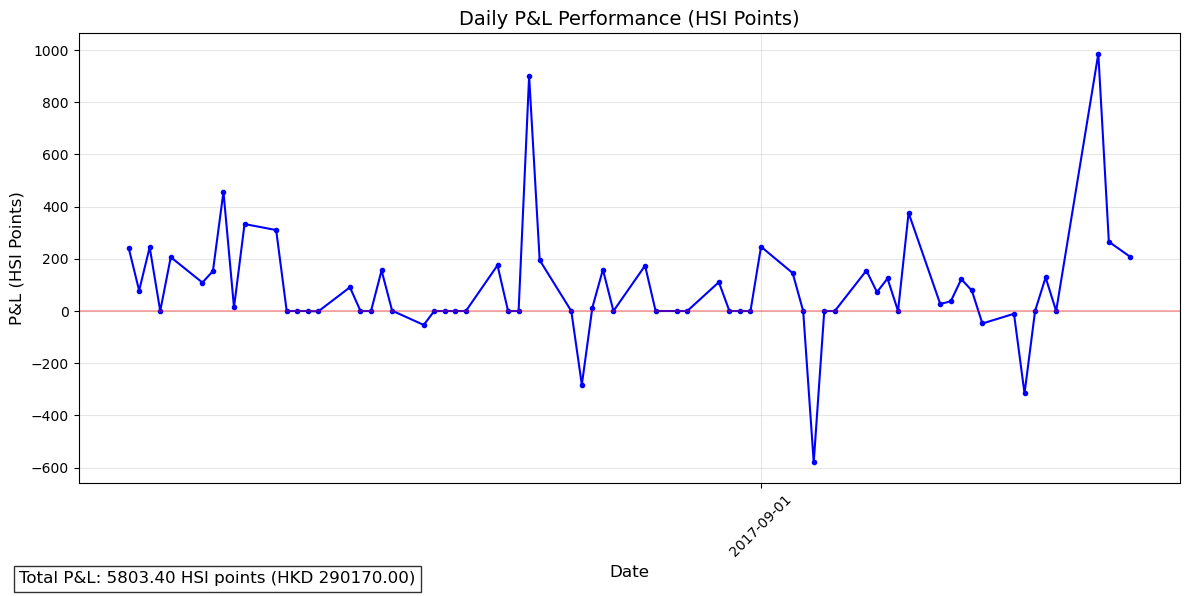

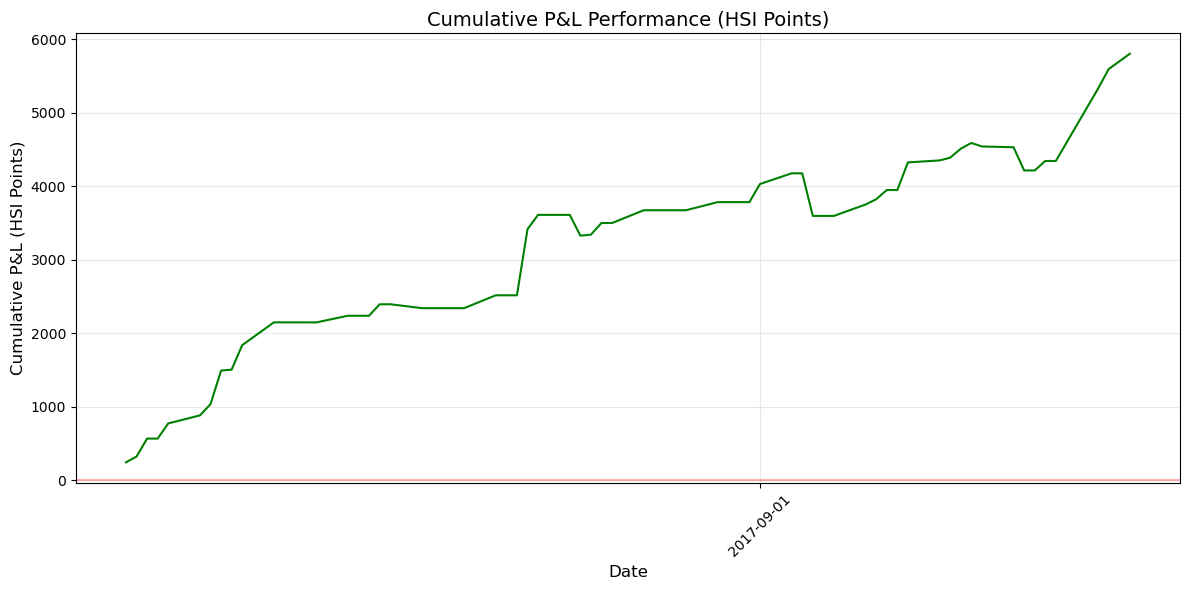

In [29]:
total_pnl = sum(daily_pnl)
total_pnl_hkd = total_pnl * 50

print(f"\nTotal P&L: {total_pnl:.2f} HSI points")
print(f"Total P&L: {total_pnl_hkd:.2f} HKD")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Convert date strings to datetime for plotting
plot_dates = [pd.to_datetime(date, format='%Y%m%d') for date in unique_dates[:len(daily_pnl)]]

# Create the daily P&L line chart
plt.figure(figsize=(12, 6))
plt.plot(plot_dates, daily_pnl, marker='o', linestyle='-', color='blue', markersize=3)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

# Format the plot
plt.title('Daily P&L Performance (HSI Points)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('P&L (HSI Points)', fontsize=12)
plt.grid(True, alpha=0.3)

# Format the x-axis date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

# Add cumulative P&L as text
cum_pnl = sum(daily_pnl)
plt.figtext(0.02, 0.02, f'Total P&L: {cum_pnl:.2f} HSI points (HKD {cum_pnl*50:.2f})', 
            fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('daily_pnl_chart.png')
plt.show()

# Create cumulative P&L chart
cumulative_pnl = np.cumsum(daily_pnl)
plt.figure(figsize=(12, 6))
plt.plot(plot_dates, cumulative_pnl, marker='', linestyle='-', color='green')
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)

# Format the cumulative plot
plt.title('Cumulative P&L Performance (HSI Points)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative P&L (HSI Points)', fontsize=12)
plt.grid(True, alpha=0.3)

# Format the x-axis date labels
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('cumulative_pnl_chart.png')
plt.show()
